# Representativeness Analysis

## Preparation for the analysis

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import glob
import os
import csv
import numpy as np
import matplotlib
from IPython.display import HTML
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.5)
%matplotlib inline

In [2]:
# Construct the dataframe from BoS Data
amsa2013 = pd.read_excel('https://s3-us-west-2.amazonaws.com/open-skills-public/BLS_OES/oesm13ma/aMSA_M2013_dl.xls')
bos2013 = pd.read_excel('https://s3-us-west-2.amazonaws.com/open-skills-public/BLS_OES/oesm13ma/BOS_M2013_dl.xls')
msa2013_1 = pd.read_excel('https://s3-us-west-2.amazonaws.com/open-skills-public/BLS_OES/oesm13ma/MSA_M2013_dl_1_AK_IN.xls')
msa2013_2 = pd.read_excel('https://s3-us-west-2.amazonaws.com/open-skills-public/BLS_OES/oesm13ma/MSA_M2013_dl_2_KS_NY.xls')
msa2013_3 = pd.read_excel('https://s3-us-west-2.amazonaws.com/open-skills-public/BLS_OES/oesm13ma/MSA_M2013_dl_3_OH_WY.xls')
msa2013 = pd.concat([msa2013_1, msa2013_2, msa2013_3, amsa2013, bos2013], ignore_index=True)
# Clean non-numeric value in 'TOT_EMP'
msa2013.loc[msa2013[[not isinstance(x, int) for x in msa2013['TOT_EMP']]].index, 'TOT_EMP'] = 0

In [3]:
# Construct the dataframe from Data@Work Data
datworkq1 = pd.read_csv('https://open-skills-datasets.s3-us-west-2.amazonaws.com/geo_soc_common_count/2013Q1.csv')
datworkq2 = pd.read_csv('https://open-skills-datasets.s3-us-west-2.amazonaws.com/geo_soc_common_count/2013Q2.csv')
datworkq3 = pd.read_csv('https://open-skills-datasets.s3-us-west-2.amazonaws.com/geo_soc_common_count/2013Q3.csv')
datworkq4 = pd.read_csv('https://open-skills-datasets.s3-us-west-2.amazonaws.com/geo_soc_common_count/2013Q4.csv')
datwork2013 = pd.concat([datworkq1, datworkq2, datworkq3, datworkq4], ignore_index=True)
datwork2013['major_group'] = pd.Series(list(map(lambda x: x[:2]+'-0000', datwork2013['soc_code'])))

In [4]:
# Construct Lookup for fips and name
d = datwork2013[['cbsa_fips','cbsa_name']].drop_duplicates()
lookup = dict(zip(d['cbsa_fips'],d['cbsa_name']))

In [5]:
msa2013.head()

,PRIM_STATE,AREA,AREA_NAME,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,JOBS_1000,LOC QUOTIENT,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,AK,11260,"Anchorage, AK",00-0000,All Occupations,total,175540,2.1,1000,1,...,20.76,32.69,45.88,20910,28680,43180,68000,95430,NaN,NaN
1,AK,11260,"Anchorage, AK",11-0000,Management Occupations,major,10370,2.4,59.087,1.2,...,46.09,63.15,85.96,51940,69250,95860,131360,178810,NaN,NaN
2,AK,11260,"Anchorage, AK",11-1011,Chief Executives,detailed,320,4.5,1.817,0.97,...,76.9,#,#,97190,115700,159940,#,#,NaN,NaN
3,AK,11260,"Anchorage, AK",11-1021,General and Operations Managers,detailed,4010,3.2,22.828,1.53,...,45.74,64.77,89.36,52020,66980,95140,134720,185870,NaN,NaN
4,AK,11260,"Anchorage, AK",11-2011,Advertising and Promotions Managers,detailed,40,27.6,0.207,0.96,...,32.49,49.3,56.59,42670,49100,67580,102550,117710,NaN,NaN


In [6]:
datwork2013.head()

,cbsa_fips,cbsa_name,state_code,soc_code,counts_total,major_group
0,13980,"Blacksburg-Christiansburg-Radford, VA Metro Area",VA,41-3031.01,3,41-0000
1,24820,"Greenville, OH Micro Area",OH,41-3031.02,1,41-0000
2,39300,"Providence-New Bedford-Fall River, RI-MA Metro...",RI,17-2112.00,1,17-0000
3,25420,"Harrisburg-Carlisle, PA Metro Area",PA,43-5061.00,1,43-0000
4,38060,"Phoenix-Mesa-Glendale, AZ Metro Area",AZ,43-4051.03,24,43-0000


In [7]:
dw2013q1 = pd.read_csv('../Data@Work/2013Q1.csv')
dw2013q2 = pd.read_csv('../Data@Work/2013Q2.csv')
dw2013q3 = pd.read_csv('../Data@Work/2013Q3.csv')
dw2013q4 = pd.read_csv('../Data@Work/2013Q4.csv')
dw2013 = pd.concat([dw2013q1, dw2013q2, dw2013q3, dw2013q4], ignore_index=True)

In [8]:
dw2013.head()

,soc_code,counts_total
0,53-5021.02,3
1,35-3022.01,14
2,19-2012.00,2
3,47-2111.00,82
4,31-9097.00,51


In [9]:
onetdict ={'11': 'Management Occupations',
           '13': 'Business and Financial Operations Occupations',
           '15': 'Computer and Mathematical Occupations',
           '17': 'Architecture and Engineering Occupations',
           '19': 'Life, Physical, and Social Science Occupations',
           '21': 'Community and Social Service Occupations',
           '23': 'Legal Occupations',
           '25': 'Education, Training, and Library Occupations',
           '27': 'Arts, Design, Entertainment, Sports, and Media Occupations',
           '29': 'Healthcare Practitioners and Technical Occupations',
           '31': 'Healthcare Support Occupations',
           '33': 'Protective Service Occupations',
           '35': 'Food Preparation and Serving Related Occupations',
           '37': 'Building and Grounds Cleaning and Maintenance',
           '39': 'Personal Care and Service Occupations',
           '41': 'Sales and Related Occupations', 
           '43': 'Office and Administrative Support Occupations',
           '45': 'Farming, Fishing, and Forestry Occupations',
           '47': 'Construction and Extraction Occupations', 
           '49': 'Installation, Maintenance, and Repair Occupations', 
           '51': 'Production Occupations', 
           '53': 'Transportation and Material Moving Occupations', 
           '55': 'Military Specific Occupations',
           '99': 'Unknown'}

In [18]:
def occupation_cross_states(df, to_percentage=False, normalized=False):
    try:
        occ_counts = df[df['OCC_GROUP']=='total'].groupby('PRIM_STATE')['TOT_EMP'].sum()
    except:
        occ_counts = df.groupby(['state_code', 'major_group'])['counts_total'].sum().groupby(level=0).sum()
    
    total = occ_counts.sum()
    
    if normalized:
        occ_counts = (occ_counts - occ_counts.min()) / (occ_counts.max() - occ_counts.min())
        #ax = occ_counts.plot.bar(figsize=(20,10), title='Occupation ')
        
    if to_percentage:
        occ_counts = occ_counts / occ_counts.sum()
        #ax = occ_counts.plot.bar(figsize=(20,10), title='Occupation ')
        #ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in vals])
    
    
    #ax.set_ylabel('Occupations')
    #ax.set_xlabel('States')
    #ax.set_xticklabels(occ_counts.index,rotation=60)
    return occ_counts.to_frame()

def compare_state(state):
    
    area_name1 = 'BLS - ' + state
    area1 = msa2013[(msa2013['OCC_GROUP']=='major') & (msa2013['PRIM_STATE']==state)].groupby('OCC_CODE')['TOT_EMP'].aggregate(np.sum).to_frame()
    diff = set([str(11+2*x)+'-0000' for x in range(1, 23)]) - set(area1.index)
    area1 = area1 / area1.sum()
    area1.columns=[area_name1]
    area1 = area1.append(pd.DataFrame({area_name1: [0]*len(diff)}, index=diff))
    area1.sort_index(inplace=True)
    
    area_name2 = 'Data@Work - ' + state
    area2 = datwork2013[datwork2013['state_code']==state].groupby('major_group')['counts_total'].sum().to_frame()
    diff = set([str(11+2*x)+'-0000' for x in range(1, 23)]) - set(area2.index)
    area2 = area2 / area2.sum()
    area2.columns=[area_name2]
    area2 = area2.append(pd.DataFrame({area_name2: [0]*len(diff)}, index=diff))
    area2.sort_index(inplace=True)
    
    df_list = [area1, area2]
    data = pd.concat(df_list, axis=1, join_axes=[df_list[0].index])
    ax = data.plot.bar(figsize=(20,10))
    vals = ax.get_yticks()
    ax.set_xlabel('Occupation Major Groups')
    ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in vals])
    ax.set_xticklabels(df_list[0].index,rotation=60)
    #ax.set_title('Correlation: %.4f' % data.corr().iloc[1].iloc[0])
    import matplotlib.offsetbox as offsetbox 
    a = ax.legend()
    box = a._legend_box
    txt = offsetbox.TextArea('Correlation: %.4f' % data.corr().iloc[1].iloc[0], textprops={'size':16,'weight':'bold'})
    box.get_children().append(txt)
    box.set_figure(box.figure)
    
def compare_cbsa(fip_list):
    df_list = []
    for fip in fip_list:
        area_name = 'Data@Work - ' + datwork2013[datwork2013['cbsa_fips']==fip]['cbsa_name'].iloc[0]
        area = datwork2013[datwork2013['cbsa_fips']==fip].groupby('major_group')['counts_total'].sum().to_frame()
        diff = set([str(11+2*x)+'-0000' for x in range(1, 23)]) - set(area.index)
        area = area / area.sum()
        area.columns=[area_name]
        area = area.append(pd.DataFrame({area_name: [0]*len(diff)}, index=diff))
        area.sort_index(inplace=True)
        df_list.append(area)
    
    data = pd.concat(df_list, axis=1, join_axes=[df_list[0].index])
    ax = data.plot.bar(figsize=(20,10))
    vals = ax.get_yticks()
    ax.set_xlabel('Occupation Major Groups')
    ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in vals])
    ax.set_xticklabels(df_list[0].index,rotation=60)
    #ax.set_title('Correlation: %.4f' % data.corr().iloc[1].iloc[0])
    
    return data.corr()

def compare_msa(fips):
    
    area_name1 = 'BLS - ' + msa2013[(msa2013['AREA']==fips)]['AREA_NAME'].iloc[0]
    area1 = msa2013[(msa2013['OCC_GROUP']=='major') & (msa2013['AREA']==fips)].groupby('OCC_CODE')['TOT_EMP'].aggregate(np.sum).to_frame()
    diff = set([str(11+2*x)+'-0000' for x in range(1, 23)]) - set(area1.index)
    area1 = area1 / area1.sum()
    area1.columns=[area_name1]
    area1 = area1.append(pd.DataFrame({area_name1: [0]*len(diff)}, index=diff))
    area1.sort_index(inplace=True)
    
    area_name2 = 'Data@Work - ' + datwork2013[datwork2013['cbsa_fips']==fips]['cbsa_name'].iloc[0]
    area2 = datwork2013[datwork2013['cbsa_fips']==fips].groupby('major_group')['counts_total'].sum().to_frame()
    diff = set([str(11+2*x)+'-0000' for x in range(1, 23)]) - set(area2.index)
    area2 = area2 / area2.sum()
    area2.columns=[area_name2]
    area2 = area2.append(pd.DataFrame({area_name2: [0]*len(diff)}, index=diff))
    area2.sort_index(inplace=True)
    
    df_list = [area1, area2]
    data = pd.concat(df_list, axis=1, join_axes=[df_list[0].index])
    ax = data.plot.bar(figsize=(20,10))
    vals = ax.get_yticks()
    ax.set_xlabel('Occupation Major Groups')
    ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in vals])
    ax.set_xticklabels(df_list[0].index,rotation=60)
    #ax.set_title('Correlation: %.4f' % data.corr().iloc[1].iloc[0])
    
    import matplotlib.offsetbox as offsetbox 
    a = ax.legend()
    box = a._legend_box
    txt = offsetbox.TextArea('Correlation: %.4f' % data.corr().iloc[1].iloc[0], textprops={'size':16,'weight':'bold'})
    box.get_children().append(txt)
    box.set_figure(box.figure)
    


# Difference between BLS and Data@Work in 2013

## Summary

In [11]:
num_msa = msa2013['AREA'].unique().shape[0]
num_cbsa = datwork2013['cbsa_fips'].unique().shape[0]

counts_employment = msa2013[msa2013['OCC_GROUP']=='total']['TOT_EMP'].sum()
counts_jobposting = dw2013['counts_total'].sum()

unique_soc_msa = msa2013[msa2013['OCC_GROUP'] == 'major']['OCC_CODE'].unique().shape[0]
unique_soc_datwork = datwork2013['major_group'].unique().shape[0]



In [12]:
summary = '''<table class="table table-striped">
<th></th><th>BLS</th><th>Data@Work</th>
<tr>
    <td>Counts</td>
    <td>{employment}</td>
    <td>{jobposting}</td>
</tr>
<tr>
    <td>Geological Granularities</td>
    <td>{g_msa}</td>
    <td>{g_cbsa}</td>
</tr>
<tr>
    <td>SOC Major Groups</td>
    <td>{soc_msa}</td>
    <td>{soc_cbsa}</td>
</tr>
</table>
'''.format(g_msa=num_msa, 
           g_cbsa=num_cbsa, 
           employment=counts_employment,
           jobposting=counts_jobposting,
           soc_msa=unique_soc_msa,
           soc_cbsa=unique_soc_datwork)
HTML(summary)

Counts,169657540,2373163
Geological Granularities,586,950
SOC Major Groups,22,23


## Total Job Distribution By State

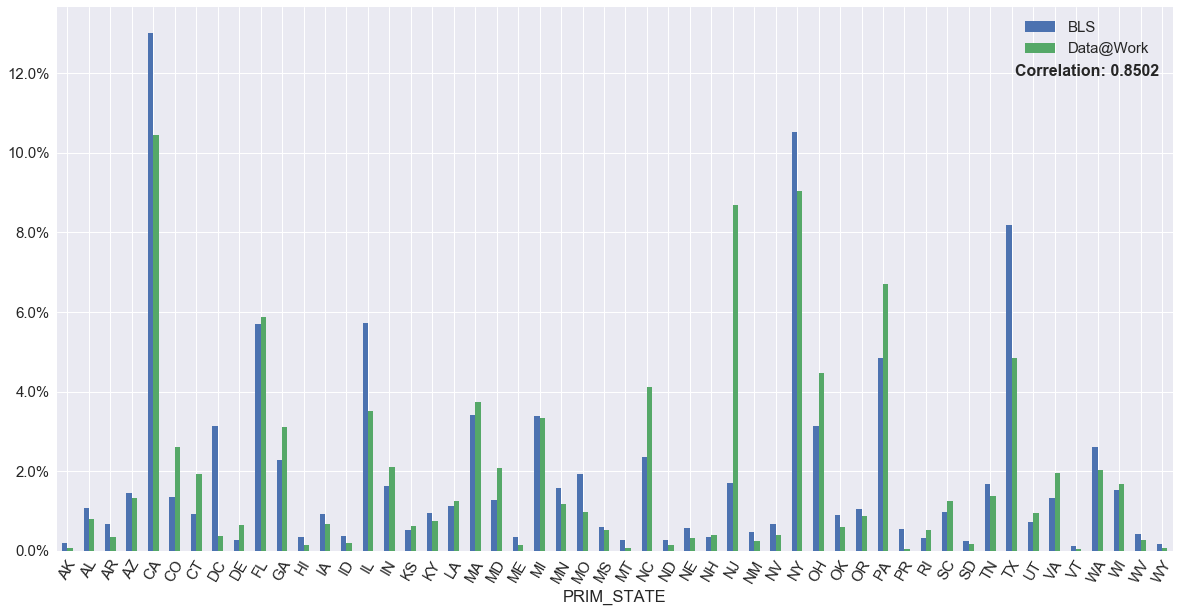

In [13]:
msa2013_cross_states = occupation_cross_states(msa2013, to_percentage=True)
msa2013_cross_states.columns = ['BLS']
datwork2013_cross_states = occupation_cross_states(datwork2013, to_percentage=True)
datwork2013_cross_states.columns = ['Data@Work']
df_list = [msa2013_cross_states, datwork2013_cross_states]
data = pd.concat(df_list, axis=1, join_axes=[df_list[0].index])
ax = data.plot.bar(figsize=(20,10))
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in vals])
ax.set_xticklabels(df_list[0].index,rotation=60)
#ax.set_title('Correlation: %.4f' % data.corr().iloc[1].iloc[0])
import matplotlib.offsetbox as offsetbox 
a = ax.legend()
box = a._legend_box
txt = offsetbox.TextArea('Correlation: %.4f' % data.corr().iloc[1].iloc[0], textprops={'size':16, 'weight':'bold'})
box.get_children().append(txt)
box.set_figure(box.figure)

## Total Occupation Distribution

### Total Occupation Distribution for BLS Data

In [14]:
occ_msa = msa2013[msa2013['OCC_GROUP']=='major'].groupby('OCC_CODE')['TOT_EMP'].sum().to_frame()
occ_name = 'BLS'
diff = set([str(11+2*x)+'-0000' for x in range(1, 23)]) - set(occ_msa.index)
occ_msa = occ_msa / occ_msa.sum()
occ_msa.columns=[occ_name]
occ_msa = occ_msa.append(pd.DataFrame({occ_name: [0]*len(diff)}, index=diff))
occ_msa.sort_index(inplace=True)

### Total Occupation Distribution for Data@Work Data

In [15]:
occ_datwork = datwork2013.groupby('major_group')['counts_total'].sum().to_frame()
occ_name = 'Data@Work'
diff = set([str(11+2*x)+'-0000' for x in range(1, 23)]) - set(occ_datwork.index)
occ_datwork = occ_datwork / occ_datwork.sum()
occ_datwork.columns=[occ_name]
occ_datwork = occ_datwork.append(pd.DataFrame({occ_name: [0]*len(diff)}, index=diff))
occ_datwork.sort_index(inplace=True)

### Plot in the same graph

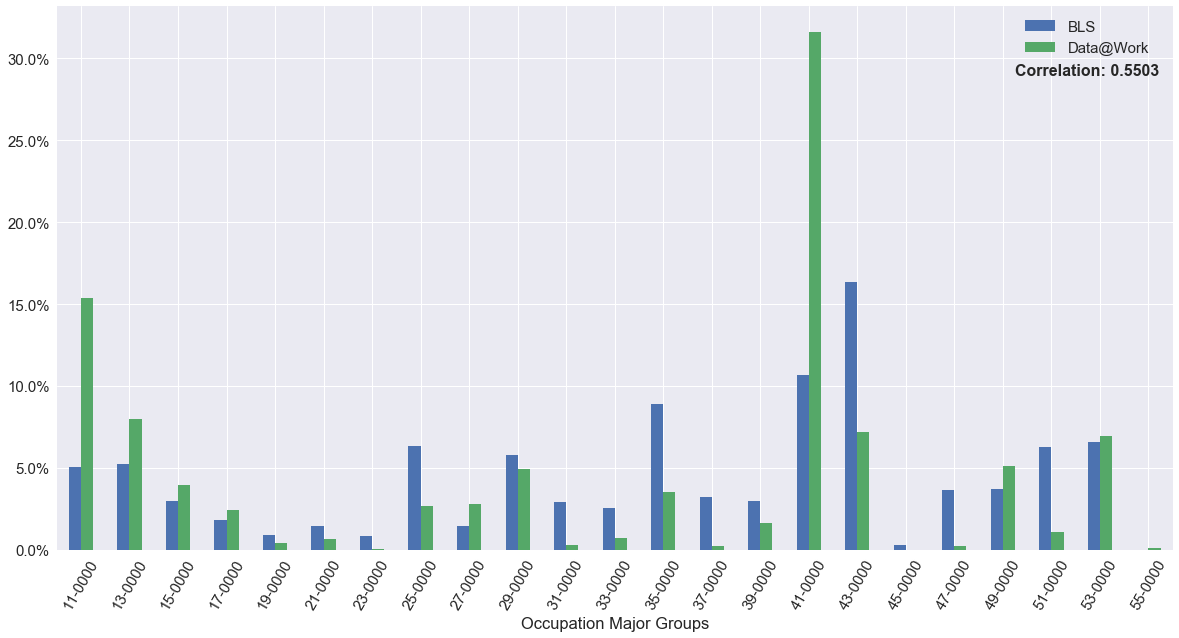

In [16]:
df_list = [occ_msa, occ_datwork]
data = pd.concat(df_list, axis=1, join_axes=[df_list[0].index])
ax = data.plot.bar(figsize=(20,10))
vals = ax.get_yticks()
ax.set_xlabel('Occupation Major Groups')
ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in vals])
ax.set_xticklabels(df_list[0].index,rotation=60)
# ax.set_title('Correlation: %.4f' % data.corr().iloc[1].iloc[0])
import matplotlib.offsetbox as offsetbox 
a = ax.legend()
box = a._legend_box
txt = offsetbox.TextArea('Correlation: %.4f' % data.corr().iloc[1].iloc[0], textprops={'size':16, 'weight':'bold'})
box.get_children().append(txt)
box.set_figure(box.figure)

## Occupation Distribution of some State

### New York State

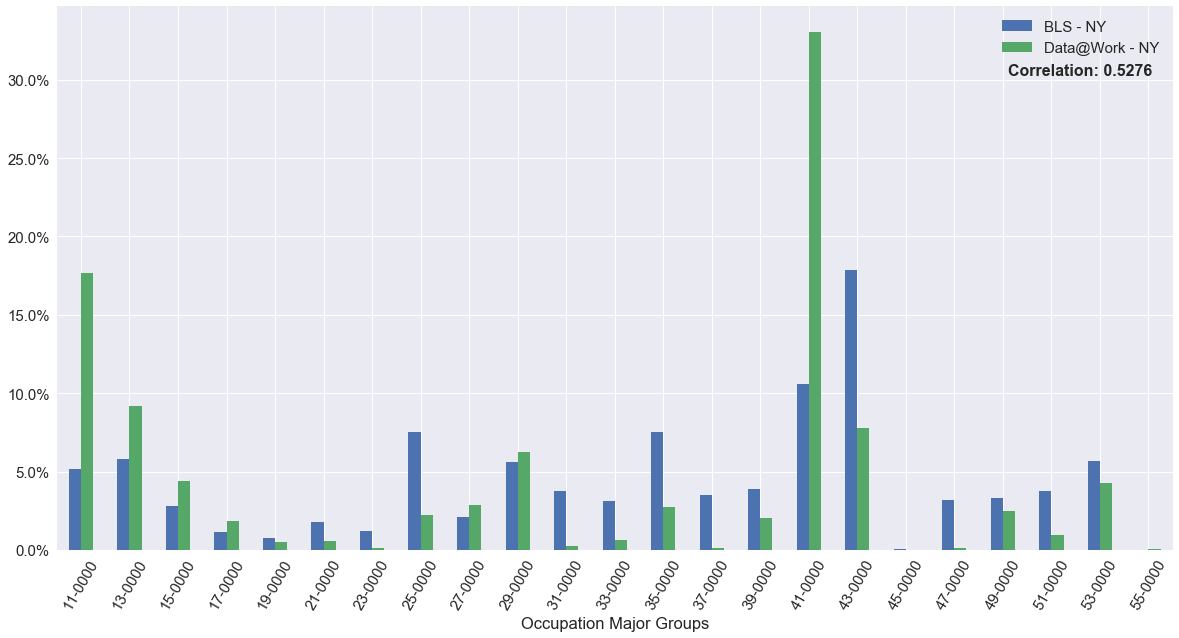

In [19]:
compare_state('NY')

### Illinois State

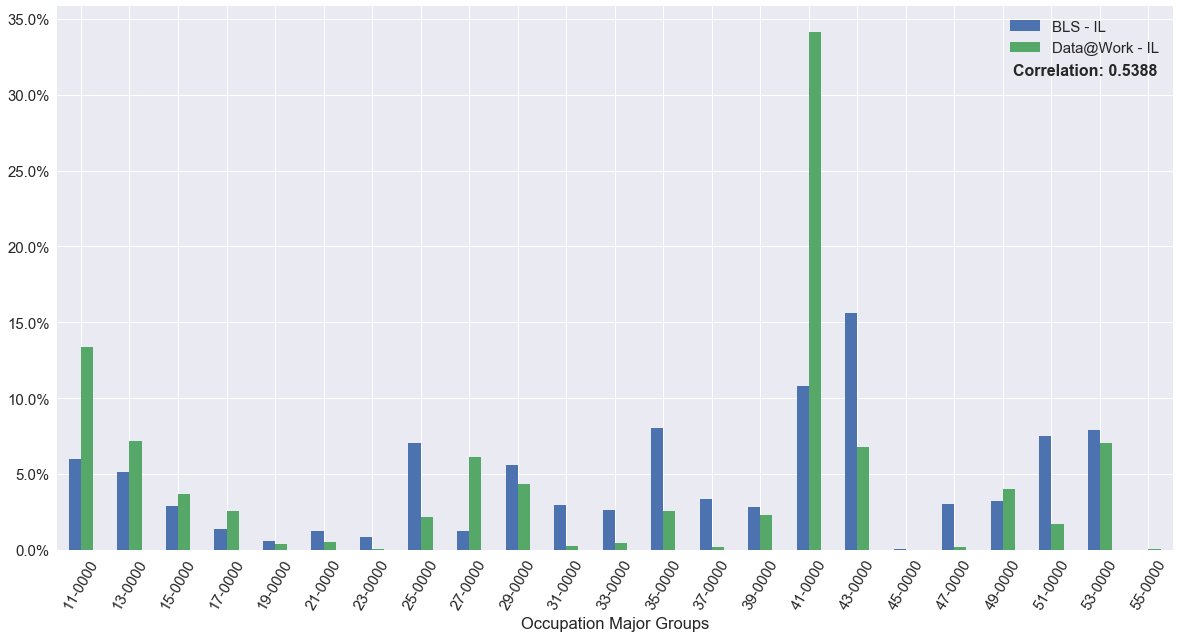

In [20]:
compare_state('IL')

# Occupation Distribution for some MSA

### Chicago

In [22]:
reverse_lookup = {v: k for k, v in lookup.items()}

Chicago-Joliet-Naperville, IL-IN-WI Metro Area


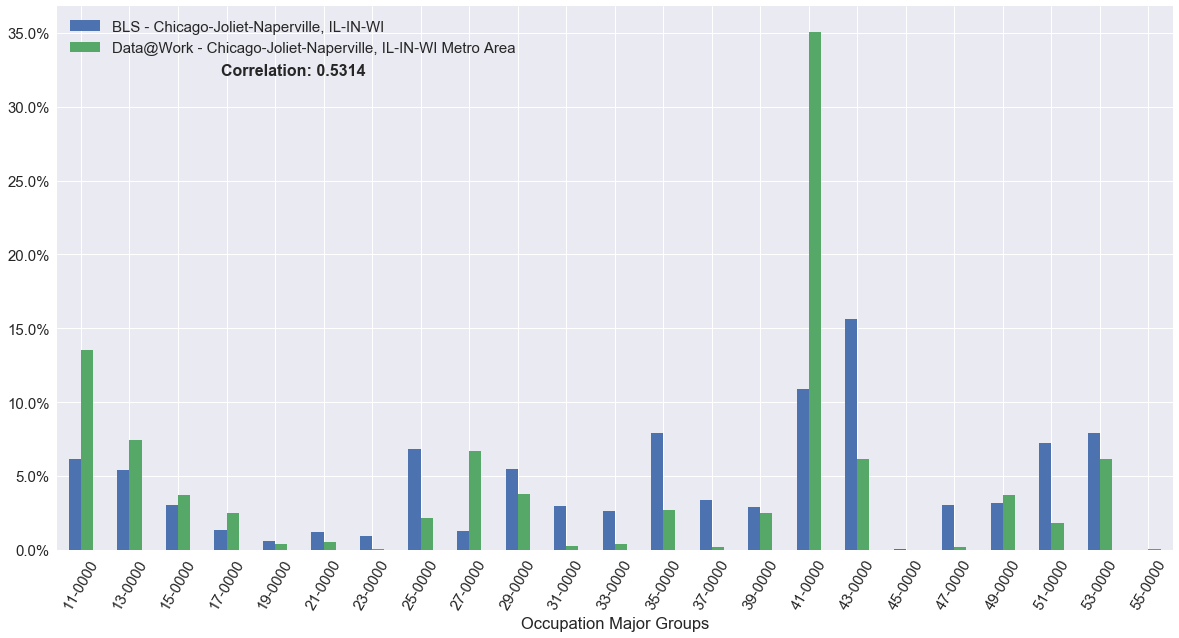

In [23]:
MSA = 'Chicago'
for name in reverse_lookup.keys():
    if MSA.lower() in name.lower():
        print(name)
        compare_msa(reverse_lookup[name])

Detroit-Warren-Livonia, MI Metro Area


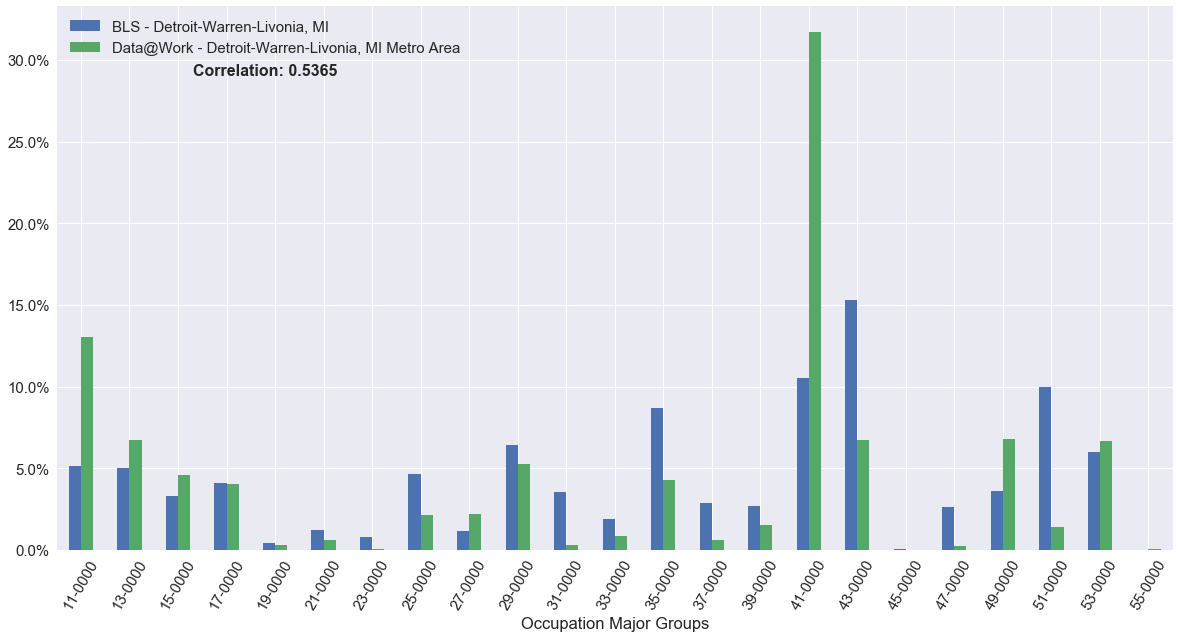

In [24]:
MSA = 'Detroit'
for name in reverse_lookup.keys():
    if MSA.lower() in name.lower():
        print(name)
        compare_msa(reverse_lookup[name])

## SOC code distribution for a major group

Rochester, NY Metro Area


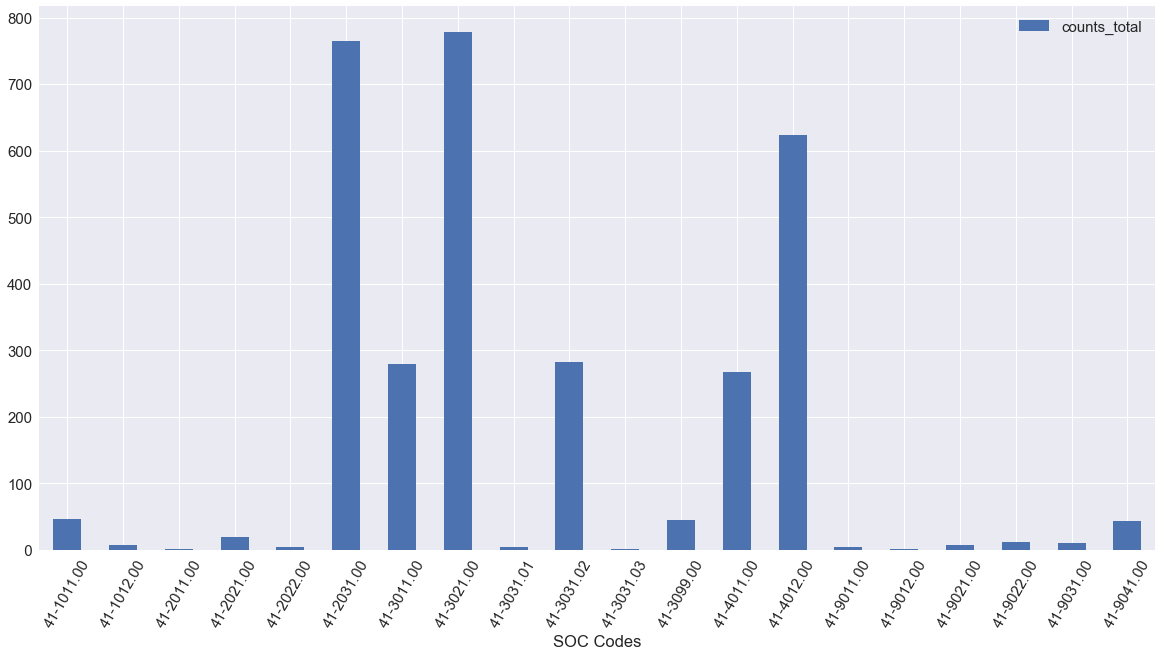

In [25]:
fip = 40380
print(lookup[fip])
data = datwork2013[(datwork2013['cbsa_fips']==fip) & (datwork2013['major_group']=='41-0000')].groupby('soc_code')['counts_total'].sum().to_frame()
ax = data.plot.bar(figsize=(20,10))
vals = ax.get_yticks()
ax.set_xlabel('SOC Codes')
ax.set_yticklabels(['{:3.0f}'.format(x) for x in vals])
ax.set_xticklabels(data.index,rotation=60)

## Compare with different MSAs in Data@Work

Chicago-Joliet-Naperville, IL-IN-WI Metro Area
New York-Northern New Jersey-Long Island, NY-NJ-PA Metro Area
San Jose-Sunnyvale-Santa Clara, CA Metro Area


,"Data@Work - Chicago-Joliet-Naperville, IL-IN-WI Metro Area","Data@Work - New York-Northern New Jersey-Long Island, NY-NJ-PA Metro Area","Data@Work - San Jose-Sunnyvale-Santa Clara, CA Metro Area"
"Data@Work - Chicago-Joliet-Naperville, IL-IN-WI Metro Area",1.000000,0.973621,0.951607
"Data@Work - New York-Northern New Jersey-Long Island, NY-NJ-PA Metro Area",0.973621,1.000000,0.968905
"Data@Work - San Jose-Sunnyvale-Santa Clara, CA Metro Area",0.951607,0.968905,1.000000


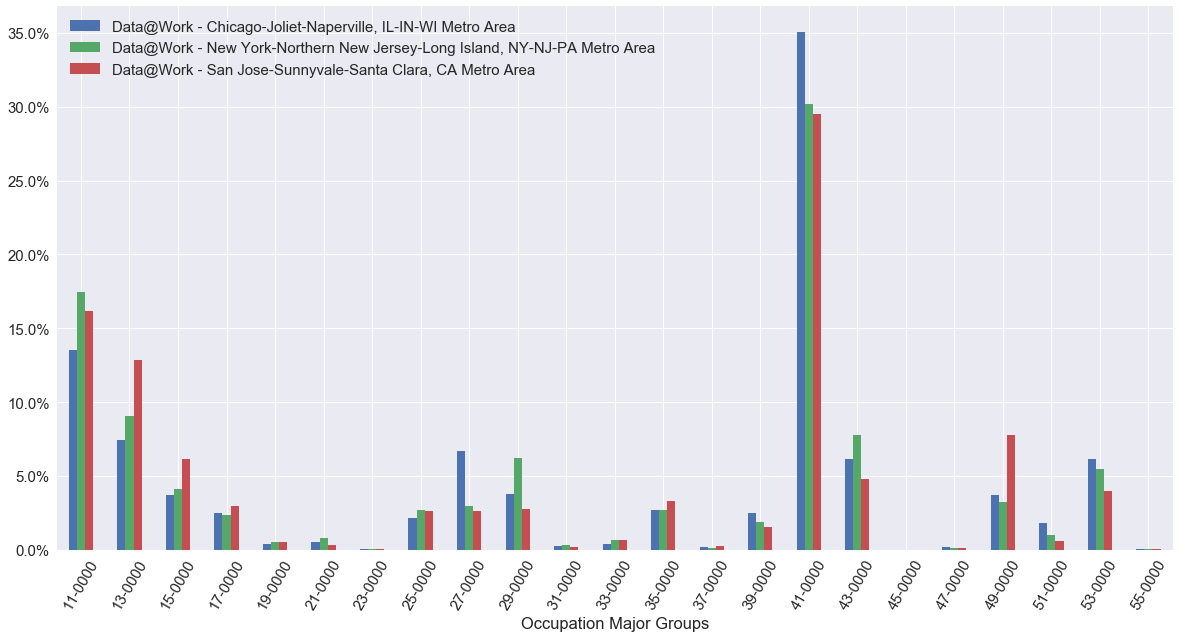

In [26]:
fips = [16980, 35620, 41940]
for f in fips:
    print(lookup[f])
compare_cbsa(fips)